In [56]:
#Imports

#Pandas: Reading and analyzing data
import pandas as pd
#Numerical calcuations
import numpy as np
#statistical data visualization
import seaborn as sns
#Use Dates in Datetime Format
import datetime
#Tensorflow
import tensorflow as tf
#Keras: Open-Source deep-learning library 
from tensorflow import keras
#Building blocks of NN in Keras
from tensorflow.keras import layers
#EarlyStop to stop training early
from tensorflow.keras.callbacks import EarlyStopping
#Functional API: Layers for different models
from keras.layers import Dense, LSTM, Dropout
#Normalization
from sklearn.preprocessing import MinMaxScaler
#Standardization
from sklearn.preprocessing import StandardScaler
#Evaluate models
import math
#Evaluate MSE
from sklearn.metrics import mean_squared_error
#plot numpy array
import matplotlib.pyplot as plt
#Create Folder for modelling checkpoint
import os
#Callback to logg model fitting time
import time
from timeit import default_timer as timer
#Clear output after training
import IPython
import IPython.display
#Normalization
from sklearn.preprocessing import MinMaxScaler
#Standardization
from sklearn.preprocessing import StandardScaler

#Helper Class (Export Notebook as .py)
from windowgenerator import WindowGenerator

# Heper functions

In [23]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 

def create_model_checkpoint(model_name, save_path):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path), # create filepath to save model
        verbose=0, # only output a limited amount of text
        save_best_only=True) # save only the best model to file

#Helper function for time callback to log training time per epoch
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append((epoch, timer()-self.starttime))
        
timetaken = timecallback()

def compile_and_fit(model, window, model_name, client_name, MAX_EPOCHS, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError(), 
                    tf.keras.metrics.MeanAbsolutePercentageError(),
                    tf.keras.metrics.MeanAbsoluteError(),
                ])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, create_model_checkpoint(
                          model_name=model.name, 
                          save_path=f"model_experiments/FineTune/{model_name}/{client_name}"
                      ), timetaken])
    
    return history

In [19]:
def build_LSTM_model(
    input_shape, num_LSTM_cells, num_LSTM_layers, num_LSTM_dense_layers, num_LSTM_dense_units, LSTM_dropout,
    output_steps, num_features, model_name
):
   #Input dimensions are (N x n_past x #features)
    inputs = keras.Input(shape=input_shape, name="Input")
    #Hidden LSTM Layers
    x = layers.LSTM(num_LSTM_cells, return_sequences=True)(inputs)

    for _ in range(num_LSTM_layers):
        x = layers.LSTM(num_LSTM_cells, return_sequences=True)(x)

    x = layers.LSTM(num_LSTM_cells, return_sequences=False)(x)

    #Dropout and Dense Layers
    for _ in range(num_LSTM_dense_layers):
        x = layers.Dense(num_LSTM_dense_units, activation="relu")(x)
    x = layers.Dropout(LSTM_dropout)(x)

    #Output
    x = layers.Dense(output_steps*num_features, kernel_initializer=tf.initializers.zeros())(x)
    outputs = layers.Reshape([output_steps, num_features])(x)
    
    multi_lstm_model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return multi_lstm_model

def build_CNN_model(
    input_shape, conv_width, num_CNN_layers, num_CNN_filters, num_CNN_dense_layers, 
    num_CNN_dense_units, CNN_dropout, output_steps, num_features, model_name
):
   #Input dimensions are (N x n_past x #features)
    inputs = keras.Input(shape=input_shape, name="Input")
    #Hidden LSTM Layers
    x = layers.Lambda(lambda x: x[:, -conv_width:, :])(inputs)

    for _ in range(num_CNN_layers):
        x = layers.Conv1D(num_CNN_filters, kernel_size=(conv_width), activation='relu', padding="same")(x)
        x = layers.BatchNormalization()(x)
        #x = layers.ReLU()(x)
        
    x = layers.GlobalAveragePooling1D()(x)
    
    for _ in range(num_CNN_dense_layers):
        x = layers.Dense(num_CNN_dense_units, activation="relu")(x)
    
    x = layers.Dropout(CNN_dropout)(x)
    x = layers.Dense(output_steps*num_features, kernel_initializer=tf.initializers.zeros())(x)
    outputs = layers.Reshape([output_steps, num_features])(x)
    #Create model
    multi_conv_model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return multi_conv_model

def build_transformer_model(input_shape, output_steps, num_features, model_name):
    
    encoder_inputs = keras.layers.Input(shape=input_shape)

    #ENCODER
    #Encoder Layer 1
    x = keras.layers.MultiHeadAttention(key_dim=4, num_heads=2, dropout=0.2)(encoder_inputs, encoder_inputs)
    res1 = x + encoder_inputs #Add
    x = keras.layers.Dense(input_shape[1], activation='relu')(x) # Feed Forward Part
    res2 = x + res1 #Add
    x_out = keras.layers.LayerNormalization(epsilon=1e-6)(res2) #Norm


    #Encoder Layer 2
    x = keras.layers.MultiHeadAttention(key_dim=4, num_heads=2, dropout=0.2)(x_out, x_out)
    res1 = x + x_out #Add
    x = keras.layers.Dense(input_shape[1], activation='relu')(x) # Feed Forward Part
    res2 = x + res1 #Add
    x_out = keras.layers.LayerNormalization(epsilon=1e-6)(res2) #Norm

    encoder = keras.layers.LSTM(7, return_state=True)
    encoder_outputs_and_states = encoder(x_out)
    encoder_states = encoder_outputs_and_states[1:]
    #-----------------------------------------------------------------------------------------
    decoder_inputs = encoder_inputs

    #DECODER
    #Decoder Layer 1
    x = keras.layers.MultiHeadAttention(key_dim=4, num_heads=2, dropout=0.2)(decoder_inputs, decoder_inputs)
    res1 = x + decoder_inputs #Add
    x = keras.layers.Dense(input_shape[1], activation='relu')(x) # Feed Forward Part
    res2 = x + res1 #Add
    x_out = keras.layers.LayerNormalization(epsilon=1e-6)(res2) #Norm

    decoder = keras.layers.LSTM(7, return_state=True, return_sequences=True)
    decoder_outputs_and_states = decoder(x_out, initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0] # Only select the output of the decoder (not the states)

    #Decoder Layer 2
    x = keras.layers.MultiHeadAttention(key_dim=4, num_heads=2, dropout=0.2)(decoder_outputs, x_out)
    res1 = x + decoder_outputs #Add
    x = keras.layers.Dense(input_shape[1], activation='relu')(x) # Feed Forward Part
    res2 = x + res1 #Add
    x_out = keras.layers.LayerNormalization(epsilon=1e-6)(res2) #Norm

    decoder = keras.layers.LSTM(7, return_state=True, return_sequences=True)
    decoder_outputs_and_states = decoder(x_out, initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0] # Only select the output of the decoder (not the states)


    #Feedforward
    x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(decoder_outputs)
    x = keras.layers.Dense(output_steps*num_features, kernel_initializer=tf.initializers.zeros())(x)
    outputs = keras.layers.Reshape([output_steps, num_features])(x)

    return keras.models.Model(inputs=encoder_inputs, outputs=outputs, name='model_name') 

# Data

3


,temp,rhum,0101-ZE01-70,0101-ZE01-74,0141-ZE01-70,0141-ZE01-74,0145-ZE02-70,0213-ZE01-71,0223-ZE01-71,0223-ZE02-71,...,0430-ZE01-70,0439-ZE01-70,0439-ZE01-72,0439-ZE02-70,5311-ZE01-70,6907-ZE01-74,hour sin,hour cos,dayofweek sin,dayofweek cos
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.325866,0.963855,0.0,0.221036,0.164777,0.164777,0.055199,0.0,0.0,0.324802,...,0.0,0.0,0.0,0.286572,0.0,0.20283,0.692833,0.0,0.012536,0.38874


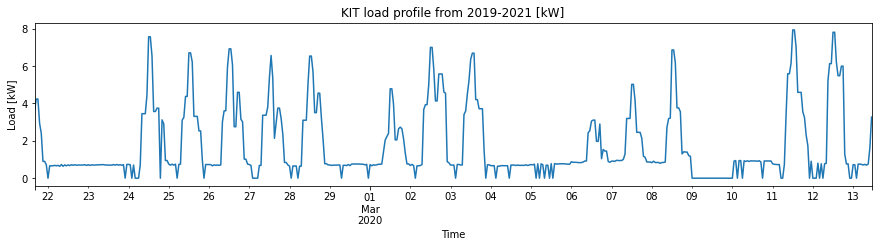

In [36]:
#Get Data

#Define Path to datafile
user = 'rs1044' #'Jonas'
filename = '00Data_KIT_2019-01-01_to_2021_12_31.csv'
path = 'C:/Users/' + user + '/bwSyncShare/02Python Code/Data/' + filename

#1.1 Data collection & Visualization

#Read CSV file to pandas dataframe; encoding= 'unicode_escape': Decode from Latin-1 source code. Default UTF-8.
df = pd.read_csv(path, encoding= 'unicode_escape', index_col='Date')
df.index = pd.to_datetime(df.index)
df_feature = df.copy()
#Drop columns with insignificant weather features
df.drop(columns=['prcp', 'wdir','pres', 'coco','dwpt', 'wpgt','wspd'], axis=1, inplace=True)
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

smart_meter_names = df.columns[2:-2][0:3]
print(len(smart_meter_names))

#Visualize
df['0213-ZE01-71'][10000:10500].plot(title="KIT load profile from 2019-2021 [kW]",
             figsize=(15,3), 
             xlabel="Time", 
             ylabel="Load [kW]",
             kind="line"
            )

#Convert Time String to seconds
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

#Sine cosine Scaling
hour = 60*60
df['hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))
df.drop('hour', axis=1, inplace=True)

daysinweek = 7*24*60*60
df['dayofweek sin'] = np.sin(timestamp_s * (2 * np.pi / daysinweek))
df['dayofweek cos'] = np.cos(timestamp_s * (2 * np.pi / daysinweek))
df.drop('dayofweek', axis=1, inplace=True)

#Min Max Sclaing
col_names = df.columns
features = df[col_names]

scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
df = pd.DataFrame(features, columns = col_names, index=df.index)
df.head(1)

# Forecasting

In [37]:
# Create Datasets for the 33 clients and for 5 and 7 features

#ds_dict[smart_meter_names][0-5] 
#    -> 0:train_df_F7, 1: val_df_F7, 2: test_df_F7, 3: train_df_F5, 4: val_df_F5, 5: test_df_F5
ds_dict = {}
n = len(df)

for client in smart_meter_names:
    
    train_df_F7 = df[0:int(n*0.7)][[client, 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]
    val_df_F7 = df[int(n*0.7):int(n*0.9)][[client, 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]
    test_df_F7 = df[int(n*0.9):][[client, 'temp', 'rhum', 'hour sin', 'hour cos', 'dayofweek sin', 'dayofweek cos']]
        
    ds_dict[client] = [train_df_F7, val_df_F7, test_df_F7]
    

# Hyperparameter

In [38]:
#ITERATING
OUT_STEPS = [12, 24] #Next 12 or 24 hours
NUM_FEATURES = [5, 7] # [F_T, F_TW] load_value, hour sin, hour cos, dayofweek sin, dayofweek cos + (temp, rhum)
INPUT_STEPS = 24
INPUT_SHAPE = [(INPUT_STEPS, NUM_FEATURES[0]), (INPUT_STEPS, NUM_FEATURES[1])]

# Windowing

In [39]:
#ds_dict[smart_meter_names][0-5] 
#    -> 0: test_df_F7, 

#windows_dict[smart_meter_names][0-3] 
#    -> 0:window_F5_H12 , 1:window_F5_H24 , 2:window_F7_H12 , 3:window_F7_H24
windows_dict = {}

for client in smart_meter_names:
    #F7_H24
    window_F7_H24 = WindowGenerator(
        input_width=INPUT_STEPS, label_width=OUT_STEPS[1], shift=OUT_STEPS[1], 
        train_df = ds_dict[client][0], val_df = ds_dict[client][1], test_df = ds_dict[client][2], label_columns=[client]
    )
    example_window = tf.stack([np.array(ds_dict[client][0][10100:10100+window_F7_H24.total_window_size]),
                               np.array(ds_dict[client][0][2000:2000+window_F7_H24.total_window_size]),
                               np.array(ds_dict[client][0][3000:3000+window_F7_H24.total_window_size])])
    example_inputs, example_labels = window_F7_H24.split_window(example_window)
    window_F7_H24.example = example_inputs, example_labels
    
    windows_dict[client] = [window_F7_H24]
    

# Model

In [40]:
final_dict = {}
final_dict['LSTM'] = {}
final_dict['CNN'] = {}
final_dict['Transformer'] = {}


In [41]:
#All models
MAX_EPOCHS = 100


#LSTM
NUM_LSTM_LAYERS = 24         #1, 2, 3, 4, 5, 6
NUM_LSTM_CELLS = 1         #16, 32, 64, 128, 256, 512
NUM_LSTM_DENSE_LAYERS= 0     #1,2,3
NUM_LSTM_DENSE_UNITS = 16   #16,32,64,128
LSTM_DROPOUT = 0.2


#CNN
CONV_WIDTH = 3
NUM_CNN_LAYERS = 4
NUM_CNN_FILTERS = 32
NUM_CNN_DENSE_LAYERS = 1
NUM_CNN_DENSE_UNITS = 32
CNN_DROPOUT = 0.2

In [42]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

In [43]:
#Build Models

multi_lstm_model = build_LSTM_model(
    input_shape = INPUT_SHAPE[1], 
    num_LSTM_cells = NUM_LSTM_CELLS,
    num_LSTM_layers = NUM_LSTM_LAYERS,
    num_LSTM_dense_layers = NUM_LSTM_DENSE_LAYERS,
    num_LSTM_dense_units = NUM_LSTM_DENSE_UNITS,
    LSTM_dropout = LSTM_DROPOUT,
    output_steps = OUT_STEPS[1],
    num_features = NUM_FEATURES[1],
    model_name = 'LSTM_F7_H24'
)

multi_conv_model = build_CNN_model(
    input_shape = INPUT_SHAPE[1], 
    conv_width = CONV_WIDTH,
    num_CNN_layers = NUM_CNN_LAYERS,
    num_CNN_filters = NUM_CNN_FILTERS,
    num_CNN_dense_layers = NUM_CNN_DENSE_LAYERS,
    num_CNN_dense_units = NUM_CNN_DENSE_UNITS,
    CNN_dropout = CNN_DROPOUT,
    output_steps = OUT_STEPS[1],
    num_features = NUM_FEATURES[1],
    model_name = 'CNN_F7_H24'
)

multi_transformer_model = build_transformer_model(
    input_shape = INPUT_SHAPE[1],
    output_steps = OUT_STEPS[1],
    num_features = NUM_FEATURES[1],
    model_name = 'Transformer_F7_H24'    
)

In [45]:
#windows_dict[smart_meter_names][0-3] 
#    -> 0:window_F5_H12 , 1:window_F5_H24 , 2:window_F7_H12 , 3:window_F7_H24
forecasts_dict_LSTM_F7_H24 = {}
forecasts_dict_CNN_F7_H24 = {}
forecasts_dict_Transformer_F7_H24 = {}

for idx, client in enumerate(smart_meter_names):
    IPython.display.clear_output()
    print("---------------------------------------------------------------------------", idx+1, "/4")
    print("---------------------------------------------------------------------------", idx+1, "/4")
    print("---------------------------------------------------------------------------", idx+1, "/4")

    #LSTM
    history = compile_and_fit(multi_lstm_model, windows_dict[client][0], model_name='LSTM_F7_H24', client_name=client, MAX_EPOCHS=MAX_EPOCHS)
    #Load best model  
    model = tf.keras.models.load_model(f"model_experiments/FineTune/LSTM_F7_H24/{client}")
    model_evaluation_test = model.evaluate(windows_dict[client][0].test)
    #Save results
    forecasts_dict_LSTM_F7_H24[client] = {
        'MSE':model_evaluation_test[0], 'RMSE':model_evaluation_test[1], 'MAPE':model_evaluation_test[2],
        'MAE':model_evaluation_test[3], 'Time':((timetaken.logs[-1][1]) / (timetaken.logs[-1][0]+1))                              
                             }

    #CNN
    history = compile_and_fit(multi_conv_model, windows_dict[client][0], model_name='CNN_F7_H24', client_name=client, MAX_EPOCHS=MAX_EPOCHS)
    #Load best model
    model = tf.keras.models.load_model(f"model_experiments/FineTune/CNN_F7_H24/{client}")
    model_evaluation_test = model.evaluate(windows_dict[client][0].test)
    #Save results
    forecasts_dict_CNN_F7_H24[client] = {
        'MSE':model_evaluation_test[0], 'RMSE':model_evaluation_test[1], 'MAPE':model_evaluation_test[2],
        'MAE':model_evaluation_test[3], 'Time':((timetaken.logs[-1][1]) / (timetaken.logs[-1][0]+1))                              
                             }

    #Transformer
    history = compile_and_fit(multi_transformer_model, windows_dict[client][0], model_name='Transformer_F7_H24', client_name=client, MAX_EPOCHS=MAX_EPOCHS)
    #Load best model
    model = tf.keras.models.load_model(f"model_experiments/FineTune/Transformer_F7_H24/{client}")
    model_evaluation_test = model.evaluate(windows_dict[client][0].test)
    #Save results
    forecasts_dict_Transformer_F7_H24[client] = {
        'MSE':model_evaluation_test[0], 'RMSE':model_evaluation_test[1], 'MAPE':model_evaluation_test[2],
        'MAE':model_evaluation_test[3], 'Time':((timetaken.logs[-1][1]) / (timetaken.logs[-1][0]+1))                              
                             }

final_dict['LSTM'] = forecasts_dict_LSTM_F7_H24
final_dict['CNN'] = forecasts_dict_CNN_F7_H24
final_dict['Transformer'] = forecasts_dict_Transformer_F7_H24

--------------------------------------------------------------------------- 3 /4
--------------------------------------------------------------------------- 3 /4
--------------------------------------------------------------------------- 3 /4
Epoch 1/100
574/574 [==============================] - ETA: 0s - loss: 0.0654 - root_mean_squared_error: 0.2557 - mean_absolute_percentage_error: 91535368.0000 - mean_absolute_error: 0.2105

INFO:tensorflow:Assets written to: model_experiments/FineTune/LSTM_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/LSTM_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 192s 299ms/step - loss: 0.0654 - root_mean_squared_error: 0.2557 - mean_absolute_percentage_error: 91535368.0000 - mean_absolute_error: 0.2105 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820 - val_mean_absolute_percentage_error: 74451464.0000 - val_mean_absolute_error: 0.1553
Epoch 2/100
574/574 [==============================] - 119s 207ms/step - loss: 0.0655 - root_mean_squared_error: 0.2560 - mean_absolute_percentage_error: 89498200.0000 - mean_absolute_error: 0.2088 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820 - val_mean_absolute_percentage_error: 74459856.0000 - val_mean_absolute_error: 0.1553
Epoch 3/100
81/81 [==============================] - 7s 30ms/step - loss: 0.0427 - root_mean_squared_error: 0.2065 - mean_absolute_percentage_error: 101577920.0000 - mean_absolute_error: 0.1812
Epoch 1/100
571/574 [============================>.] - ETA: 0s - loss: 0.0443 - root_mean_squared_error: 0.2106 - mean_absolute_percenta

INFO:tensorflow:Assets written to: model_experiments/FineTune/CNN_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/CNN_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 12s 20ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103 - mean_absolute_percentage_error: 69144912.0000 - mean_absolute_error: 0.1622 - val_loss: 0.0320 - val_root_mean_squared_error: 0.1788 - val_mean_absolute_percentage_error: 79615592.0000 - val_mean_absolute_error: 0.1407
Epoch 2/100
571/574 [============================>.] - ETA: 0s - loss: 0.0421 - root_mean_squared_error: 0.2053 - mean_absolute_percentage_error: 68086984.0000 - mean_absolute_error: 0.1581

INFO:tensorflow:Assets written to: model_experiments/FineTune/CNN_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/CNN_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 11s 19ms/step - loss: 0.0420 - root_mean_squared_error: 0.2050 - mean_absolute_percentage_error: 67849240.0000 - mean_absolute_error: 0.1578 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1783 - val_mean_absolute_percentage_error: 77968720.0000 - val_mean_absolute_error: 0.1408
Epoch 3/100
574/574 [==============================] - 10s 17ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022 - mean_absolute_percentage_error: 67293136.0000 - mean_absolute_error: 0.1554 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1820 - val_mean_absolute_percentage_error: 78049888.0000 - val_mean_absolute_error: 0.1437
Epoch 4/100
81/81 [==============================] - 0s 4ms/step - loss: 0.0386 - root_mean_squared_error: 0.1965 - mean_absolute_percentage_error: 101532904.0000 - mean_absolute_error: 0.1660
Epoch 1/100
574/574 [==============================] - ETA: 0s - loss: 0.0435 - root_mean_squared_error: 0.2086 - mean_absolute_percentage_er

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 100s 168ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086 - mean_absolute_percentage_error: 68168704.0000 - mean_absolute_error: 0.1633 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1445 - val_mean_absolute_percentage_error: 55339420.0000 - val_mean_absolute_error: 0.1121
Epoch 2/100
574/574 [==============================] - ETA: 0s - loss: 0.0415 - root_mean_squared_error: 0.2038 - mean_absolute_percentage_error: 66133584.0000 - mean_absolute_error: 0.1586

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 94s 163ms/step - loss: 0.0415 - root_mean_squared_error: 0.2038 - mean_absolute_percentage_error: 66133584.0000 - mean_absolute_error: 0.1586 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1436 - val_mean_absolute_percentage_error: 55187936.0000 - val_mean_absolute_error: 0.1110
Epoch 3/100
574/574 [==============================] - ETA: 0s - loss: 0.0409 - root_mean_squared_error: 0.2023 - mean_absolute_percentage_error: 65536008.0000 - mean_absolute_error: 0.1571

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 96s 168ms/step - loss: 0.0409 - root_mean_squared_error: 0.2023 - mean_absolute_percentage_error: 65536008.0000 - mean_absolute_error: 0.1571 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433 - val_mean_absolute_percentage_error: 55491792.0000 - val_mean_absolute_error: 0.1105
Epoch 4/100
574/574 [==============================] - ETA: 0s - loss: 0.0404 - root_mean_squared_error: 0.2009 - mean_absolute_percentage_error: 65135644.0000 - mean_absolute_error: 0.1557

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 101s 175ms/step - loss: 0.0404 - root_mean_squared_error: 0.2009 - mean_absolute_percentage_error: 65135644.0000 - mean_absolute_error: 0.1557 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1428 - val_mean_absolute_percentage_error: 55263968.0000 - val_mean_absolute_error: 0.1092
Epoch 5/100
574/574 [==============================] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.2000 - mean_absolute_percentage_error: 64883444.0000 - mean_absolute_error: 0.1548

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 100s 174ms/step - loss: 0.0400 - root_mean_squared_error: 0.2000 - mean_absolute_percentage_error: 64883444.0000 - mean_absolute_error: 0.1548 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425 - val_mean_absolute_percentage_error: 54721176.0000 - val_mean_absolute_error: 0.1087
Epoch 6/100
574/574 [==============================] - 92s 161ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - mean_absolute_percentage_error: 64654288.0000 - mean_absolute_error: 0.1541 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1426 - val_mean_absolute_percentage_error: 55606768.0000 - val_mean_absolute_error: 0.1084
Epoch 7/100
574/574 [==============================] - ETA: 0s - loss: 0.0395 - root_mean_squared_error: 0.1986 - mean_absolute_percentage_error: 64508876.0000 - mean_absolute_error: 0.1534

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 100s 174ms/step - loss: 0.0395 - root_mean_squared_error: 0.1986 - mean_absolute_percentage_error: 64508876.0000 - mean_absolute_error: 0.1534 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1421 - val_mean_absolute_percentage_error: 55009608.0000 - val_mean_absolute_error: 0.1081
Epoch 8/100
574/574 [==============================] - ETA: 0s - loss: 0.0393 - root_mean_squared_error: 0.1981 - mean_absolute_percentage_error: 64151264.0000 - mean_absolute_error: 0.1529

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 100s 173ms/step - loss: 0.0393 - root_mean_squared_error: 0.1981 - mean_absolute_percentage_error: 64151264.0000 - mean_absolute_error: 0.1529 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1418 - val_mean_absolute_percentage_error: 54939676.0000 - val_mean_absolute_error: 0.1079
Epoch 9/100
574/574 [==============================] - ETA: 0s - loss: 0.0390 - root_mean_squared_error: 0.1975 - mean_absolute_percentage_error: 63965664.0000 - mean_absolute_error: 0.1521

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 101s 176ms/step - loss: 0.0390 - root_mean_squared_error: 0.1975 - mean_absolute_percentage_error: 63965664.0000 - mean_absolute_error: 0.1521 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1416 - val_mean_absolute_percentage_error: 55341396.0000 - val_mean_absolute_error: 0.1077
Epoch 10/100
574/574 [==============================] - ETA: 0s - loss: 0.0388 - root_mean_squared_error: 0.1969 - mean_absolute_percentage_error: 63842712.0000 - mean_absolute_error: 0.1516

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 99s 173ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - mean_absolute_percentage_error: 63842712.0000 - mean_absolute_error: 0.1516 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413 - val_mean_absolute_percentage_error: 55270552.0000 - val_mean_absolute_error: 0.1076
Epoch 11/100
574/574 [==============================] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.1967 - mean_absolute_percentage_error: 63634956.0000 - mean_absolute_error: 0.1513

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 99s 172ms/step - loss: 0.0387 - root_mean_squared_error: 0.1967 - mean_absolute_percentage_error: 63634956.0000 - mean_absolute_error: 0.1513 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1413 - val_mean_absolute_percentage_error: 55111268.0000 - val_mean_absolute_error: 0.1073
Epoch 12/100
574/574 [==============================] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1963 - mean_absolute_percentage_error: 63665456.0000 - mean_absolute_error: 0.1509

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 98s 170ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - mean_absolute_percentage_error: 63665456.0000 - mean_absolute_error: 0.1509 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411 - val_mean_absolute_percentage_error: 54929204.0000 - val_mean_absolute_error: 0.1075
Epoch 13/100
574/574 [==============================] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.1959 - mean_absolute_percentage_error: 63441984.0000 - mean_absolute_error: 0.1504

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 102s 177ms/step - loss: 0.0384 - root_mean_squared_error: 0.1959 - mean_absolute_percentage_error: 63441984.0000 - mean_absolute_error: 0.1504 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1407 - val_mean_absolute_percentage_error: 54396704.0000 - val_mean_absolute_error: 0.1071
Epoch 14/100
574/574 [==============================] - ETA: 0s - loss: 0.0381 - root_mean_squared_error: 0.1953 - mean_absolute_percentage_error: 63094924.0000 - mean_absolute_error: 0.1497

INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


INFO:tensorflow:Assets written to: model_experiments/FineTune/Transformer_F7_H24\0141-ZE01-70\assets


574/574 [==============================] - 99s 172ms/step - loss: 0.0381 - root_mean_squared_error: 0.1953 - mean_absolute_percentage_error: 63094924.0000 - mean_absolute_error: 0.1497 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1403 - val_mean_absolute_percentage_error: 54092392.0000 - val_mean_absolute_error: 0.1068
Epoch 15/100
574/574 [==============================] - 91s 159ms/step - loss: 0.0381 - root_mean_squared_error: 0.1952 - mean_absolute_percentage_error: 63130120.0000 - mean_absolute_error: 0.1495 - val_loss: 0.0197 - val_root_mean_squared_error: 0.1403 - val_mean_absolute_percentage_error: 54098040.0000 - val_mean_absolute_error: 0.1066
Epoch 16/100
81/81 [==============================] - 5s 48ms/step - loss: 0.0282 - root_mean_squared_error: 0.1680 - mean_absolute_percentage_error: 79635712.0000 - mean_absolute_error: 0.1372


In [50]:
final_dict['CNN'].items()

dict_items([('0101-ZE01-70', {'MSE': 0.020146077498793602, 'RMSE': 0.14193688333034515, 'MAPE': 67092180.0, 'MAE': 0.1158374547958374, 'Time': 1.3313523333830137}), ('0101-ZE01-74', {'MSE': 0.0170803964138031, 'RMSE': 0.1306920051574707, 'MAPE': 46520712.0, 'MAE': 0.09969133883714676, 'Time': 1.522332049983864}), ('0141-ZE01-70', {'MSE': 0.03861356899142265, 'RMSE': 0.19650331139564514, 'MAPE': 101532904.0, 'MAE': 0.16599275171756744, 'Time': 2.4462270500371233})])

In [51]:
final_dict['LSTM'].items()

dict_items([('0101-ZE01-70', {'MSE': 0.020763656124472618, 'RMSE': 0.1440960019826889, 'MAPE': 72457808.0, 'MAE': 0.11569443345069885, 'Time': 31.42248266671474}), ('0101-ZE01-74', {'MSE': 0.01612089015543461, 'RMSE': 0.12696804106235504, 'MAPE': 46239428.0, 'MAE': 0.09669122844934464, 'Time': 34.93378210005661}), ('0141-ZE01-70', {'MSE': 0.042655620723962784, 'RMSE': 0.20653238892555237, 'MAPE': 101577920.0, 'MAE': 0.18117354810237885, 'Time': 39.799778166537486})])

In [52]:
final_dict['Transformer'].items()

dict_items([('0101-ZE01-70', {'MSE': 0.014569027349352837, 'RMSE': 0.12070224434137344, 'MAPE': 53952704.0, 'MAE': 0.09874415397644043, 'Time': 2.42491796470302}), ('0101-ZE01-74', {'MSE': 0.010650650598108768, 'RMSE': 0.1032019704580307, 'MAPE': 33932964.0, 'MAE': 0.07747551053762436, 'Time': 9.830078862549271}), ('0141-ZE01-70', {'MSE': 0.028228243812918663, 'RMSE': 0.1680126190185547, 'MAPE': 79635712.0, 'MAE': 0.13720466196537018, 'Time': 5.708910387504147})])

In [53]:
df = pd.DataFrame(columns=['Model','MSE', 'RMSE', 'MAE', 'Time'])
sum_RMSE, sum_MSE, sum_MAE, sum_Time = 0, 0, 0, 0

for key, value in final_dict['LSTM'].items():
    sum_RMSE= sum_RMSE + value['RMSE']
    sum_MSE= sum_MSE + value['MSE']
    sum_MAE= sum_MAE + value['MAE']
    sum_Time = sum_Time + value['Time']

df = pd.concat(
    [
        df[['Model', 'RMSE', 'MSE', 'MAE', 'Time']],
        pd.DataFrame(
            [['LSTM', sum_RMSE, sum_MSE, sum_MAE, (sum_Time/ 3)]], 
            #index=df.index, 
            columns=['Model', 'RMSE', 'MSE', 'MAE', 'Time']
        )
    ], axis=0
)

sum_RMSE, sum_MSE, sum_MAE, sum_Time = 0, 0, 0, 0
for key, value in final_dict['CNN'].items():
    sum_RMSE= sum_RMSE + value['RMSE']
    sum_MSE= sum_MSE + value['MSE']
    sum_MAE= sum_MAE + value['MAE']
    sum_Time = sum_Time + value['Time']

df = pd.concat(
    [
        df[['Model', 'RMSE', 'MSE', 'MAE', 'Time']],
        pd.DataFrame(
            [['CNN', sum_RMSE, sum_MSE, sum_MAE, (sum_Time/ 3)]], 
            #index=df.index, 
            columns=['Model', 'RMSE', 'MSE', 'MAE', 'Time']
        )
    ], axis=0
)

sum_RMSE, sum_MSE, sum_MAE, sum_Time = 0, 0, 0, 0
for key, value in final_dict['Transformer'].items():
    sum_RMSE= sum_RMSE + value['RMSE']
    sum_MSE= sum_MSE + value['MSE']
    sum_MAE= sum_MAE + value['MAE']
    sum_Time = sum_Time + value['Time']

df = pd.concat(
    [
        df[['Model', 'RMSE', 'MSE', 'MAE', 'Time']],
        pd.DataFrame(
            [['Transformer', sum_RMSE, sum_MSE, sum_MAE, (sum_Time/ 3)]], 
            #index=df.index, 
            columns=['Model', 'RMSE', 'MSE', 'MAE', 'Time']
        )
    ], axis=0
)

In [54]:
df

,Model,RMSE,MSE,MAE,Time
0,LSTM,0.477596,0.079540,0.393559,35.385348
0,CNN,0.469132,0.075840,0.381522,1.766637
0,Transformer,0.391917,0.053448,0.313424,5.987969


In [ ]:
final_name = r"C:\Users\jonas\bwSyncShare\02Python Code\model_experiments\FineTune\CNN_fine_tuning_results.csv"
#df.to_csv(final_name)

In [58]:
final_name = r"C:\Users\rs1044\bwSyncShare\02Python Code\model_experiments\FineTune\LSTM_fine_tuning_results.csv"
df = pd.read_csv(final_name, encoding= 'unicode_escape')
df

,Unnamed: 0,Test_Case,RMSE,MSE,MAE,Time
0,0,L1_C16_DL1_DU16,0.572807,0.084361,0.461178,2.971124
1,1,L1_C16_DL1_DU32,0.549651,0.078314,0.443288,4.365552
2,2,L1_C16_DL0_DU32,0.570663,0.084042,0.457180,4.437855
3,3,L4_C16_DL0_DU32,0.593683,0.089635,0.470715,6.647724
4,4,L4_C32_DL0_DU32,0.597251,0.090928,0.479347,13.653494
5,5,L4_C8_DL1_DU16,0.671669,0.118445,0.564073,15.294244
6,6,L8_C8_DL0_DU16,0.672715,0.118770,0.564959,16.950110
7,7,L4_C4_DL0_DU16,0.607629,0.094304,0.501911,16.082034
8,0,L24_C1_DL0_DU16_DO1,0.681296,0.121143,0.572247,31.304396


In [59]:
final_name = r"C:\Users\rs1044\bwSyncShare\02Python Code\model_experiments\FineTune\CNN_fine_tuning_results.csv"
df = pd.read_csv(final_name, encoding= 'unicode_escape')
df

,Unnamed: 0,Test_Case,RMSE,MSE,MAE,Time
0,0,CW3_L1_F256_D1_DU32,0.609200,0.096326,0.484167,0.398861
1,0,CW3_L1_F8_D0_DU32,0.609262,0.097160,0.495353,0.356888
2,0,CW3_L1_F16_D0_DU32,0.605587,0.096209,0.489842,0.302683
3,0,CW3_L1_F24_D0_DU32,0.603218,0.095112,0.485441,0.326675
4,0,CW3_L1_F32_D0_DU32,0.611691,0.097684,0.492082,0.343073
5,0,CW3_L1_F64_D0_DU32,0.607900,0.096479,0.487299,0.342826
6,0,CW3_L1_F128_D0_DU32,0.609376,0.096983,0.487662,0.355401
7,0,CW3_L1_F8_D1_DU8,0.622472,0.101198,0.510760,0.259468
8,0,CW3_L1_F8_D1_DU16,0.605262,0.095242,0.494691,0.386076
9,0,CW3_L1_F8_D1_DU32,0.610856,0.096932,0.498511,0.300280
